# Toxic comment classification

In [1]:
from itertools import product
import random
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.3.0


In [5]:
train = pd.read_csv("./drive/MyDrive/datasets/toxic_comments/train.csv")
#test = pd.read_csv("./drive/MyDrive/datasets/toxic_comments/test.csv")

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Converting from multiclass to binary class

In [7]:
classSum = train.iloc[:,2:].sum(axis=1)
nonToxic =(classSum==0)
print("Total of comments, ",len(train))
print("Total number of non toxic comments: ", nonToxic.sum())
print("Total number of toxic comments: ", (classSum >= 1).sum())

Total of comments,  159571
Total number of non toxic comments:  143346
Total number of toxic comments:  16225


In [8]:
print("Number of comments with more than one label: ", (classSum > 1).sum())

Number of comments with more than one label:  9865


In [9]:
labelScore = list(train.sum(axis = 1, skipna = True))
newLabelScore = [1 if (x>0) else 0 for x in labelScore]

In [10]:
train['Toxic'] = newLabelScore
labelColumns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
data = train.drop(columns=labelColumns)

In [11]:
data.head(10)

,id,comment_text,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0
9,00040093b2687caa,alignment on this subject and which are contra...,0


### Solving undersampling by balancing the data


0    143346
1     16225
Name: Toxic, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


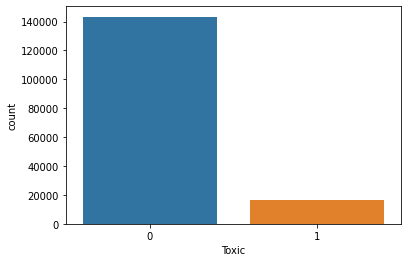

In [12]:

print(data.Toxic.value_counts())
sns.countplot(data.Toxic)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


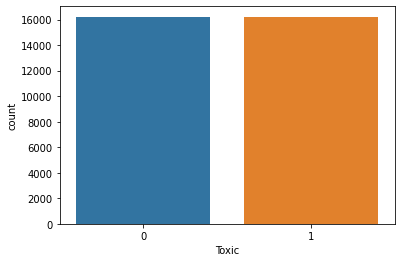

In [13]:
from sklearn.utils import resample
toxic = data[data.Toxic ==1]
not_toxic = data[data.Toxic == 0]

downsampled = resample(not_toxic,
                       replace = False, # sample without replacement
                       n_samples = len(toxic), # match minority n
                       random_state = 42) # reproducible results
data = pd.concat([downsampled, toxic])
sns.countplot(data.Toxic)

In [14]:
data.shape

(32450, 3)

In [15]:
#sample = data.sample(frac=0.0001)

In [ ]:
#sample = data[:50000]

In [ ]:
X = data["comment_text"].fillna("NODATA").values
y = data['Toxic'].values

In [16]:
class PreProcessor:
    
    def __init__(self, noise_chars):
        self.noise_chars = noise_chars #declare the noisy characters, we do not use @ or # as we need them for regex extraction
    
    def removeNoise(self, string):
        """
        This function removes noise from the text by lowering cases, removing character entities
        references, removing links, and removing given noisy characters.
        """
        string = string.lower() #converts the text to lower case 
        string = re.sub('&[a-zA-Z]+;', '', string) #remove character entities reference
        string = re.sub('http\S+', '', string)#remove links
        string = re.sub('www\S+', '', string)
        string = re.sub("\\xa0·", " ", string)
        string = re.sub("(UTC)", " ", string)
        string = re.sub('^b\s+', '', string)
        string = re.sub('@[A-Za-z0-9]+', 'user', string)
        string = re.sub("â€\x9d&lt;", "", string)
        string = re.sub("â€œ:", "", string)
        string = re.sub('pleas', 'please', string)
        string = re.sub('dont', 'do not', string)
        for char in self.noise_chars:
            string = string.replace(char, '') #removes any noisy character from the list noise_chars
        cleaned = string #the cleaned string is passed and returned
        return cleaned
    
    def removeStopwords(self, string):
        """
        This function removes stopwords from the text. It uses a corpus of stopwords from NLTK and they 
        can be extended.
        """
        words = []
        for i in string.split(" "):#split the text into spaces so it is divided into words
            words.append(i) #each word is appended in the list of words
        stop_words = stopwords.words('english') #the stopwords corpus provided by NLTK is used for remove them
        stop_words.extend(['that','thats','oh', 'aww', 'mr', 'r', 'what', 'etc', 'hey', 'within', 'foi', 'yeah', 'www', 'wa', 'em', 'am', 'i', 'me', 'dialmformurderjpg' ]) #we can extend the list of stopwords in this line
        cleaned = [w for w in words if w not in stop_words] #each word in the list of words is checked for stopwords in the corpus
        cleaned_stopwords = " ".join(cleaned)
        return cleaned_stopwords
    
    def textNormalization(self, string):
        """
        This function normalizes text by reducing length of letters in words and correcting spelling of words.
        """
        normalized = []
        tokenizer = nltk.tokenize.TweetTokenizer() #we use the TweetTokenizer to reduce length of letters in the words
        len_reduced = tokenizer.tokenize(string) #the function is applied to the text returning the length reduced
        for word in len_reduced:
            check_spell = TextBlob(word) #we use TextBlob spelling checking as the minimum lenght applied by TweetTokenizer is three letters and there can be some mispelled words
            normalized.append(str(check_spell.correct())) #it is returned the correct spell of the word and appended to normalized list of words
        normalized = " ".join(normalized)
        return normalized
    
    def stemWords(self, string):
        """
        This function performs stemming of words by chopping off inlfections of words using Port Stemmer algorithm.
        Also it corrects mispelling of words.
        """
        words = []
        stemmed = []
        for i in string.split(" "):
            words.append(i)
        stemmer = PorterStemmer() #it is used PorterStemmer to reducing inflection of words to their original word form
        stemmed_words = [stemmer.stem(w) for w in words] #it is applied to each word
        for word in stemmed_words:
            check_spell = TextBlob(word) #again, we use spelling checking as some words might result mispelled or not complete
            stemmed.append(str(check_spell.correct()))
        stemmed = " ".join(stemmed)
        return stemmed
    
    def lemmatizeWords(self, string):
        """
        This function performs word lemmatization by transforming inflections of words in their root form using
        WordNetLemmatization from NLTK. Also it checks mispelling of words.
        """
        words = []
        lemmatized = []
        for i in string.split(" "):
            words.append(i)
        lemmatizer = WordNetLemmatizer() #it is used WordNetLemmatizer to transform word inflections to root form. It is similar to stemming but it does not just chop off words.
        lemmatized_words = [lemmatizer.lemmatize(w) for w in words] #it is applied to each word
        for word in lemmatized_words:
            check_spell = TextBlob(word) #again, we use spelling checking as some words might result mispelled or not complete
            lemmatized.append(str(check_spell.correct()))
        lemmatized = " ".join(lemmatized)
        return lemmatized
    
    def wordTokenize(self, string):
        """
        This function performs word tokenization using regular expressions.
        """
        regex = "[a-zA-Z]+" #this is another form to split the sentences into words by using regular expressions
        tokenized = re.findall(regex, string) #it finds all the matching cases of the regex in the string text and it return a list of words
        return tokenized

    
    def process(self, string):
        """
        This function summarizes and apply all the preprocessing tasks.
        """
        cleaned = self.removeNoise(string)
        cleaned_stopwords = self.removeStopwords(cleaned)
        normalized = self.textNormalization(cleaned_stopwords)
        stemmed = self.stemWords(normalized)
        #lemmatized = self.lemmatizeWords(normalized)
        tokenized = " ".join(self.wordTokenize(stemmed))
        cleaned = self.removeNoise(tokenized)
        preprocessed = self.removeStopwords(cleaned)
        return preprocessed

In [ ]:
class Classifier:

  def __init__(self, pre_processor = None, max_features=20000, maxlen=100):
    self.preProcessor = pre_processor if pre_processor else PreProcessor("#@,.?!¬-\''=()") #this calls the PreProcessor class
    self.max_features = max_features
    self.maxlen = maxlen

  def prepare_data(self, X):
    """
    This function prepares the data by performing preprocessing and vectorization.
    """
    try: #try if the data is more than 1 record
      preprocessed = []
      for comment in X:
          preprocessed.append(self.preProcessor.process(comment))
      pickle.dump(preprocessed, open('preprocessed_data.pickle','wb')) #save preprocessed comments in a pickle file
      data_prepared = self.vectorize(preprocessed)
    except: #do if it is only 1 record
      preprocessed = self.preProcessor.process(X)
      data_prepared = self.vectorize(preprocessed)

    return data_prepared

  def get_model(self):
    """
    A Keras model consists of:
    An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
    A set of weights values (the "state of the model").
    An optimizer state (defined by compiling the model).
    A set of losses and metrics (defined by compiling the model).
    """
    #define the architecture of the neural network
    embed_size = 128
    inp = Input(shape=(self.maxlen, )) #input layer
    x = Embedding(self.max_features, embed_size)(inp) #useful for NLP tasks
    x = Bidirectional(LSTM(50, return_sequences=True))(x) #50 neurons; bidirectional used for give information backwards
    x = GlobalMaxPool1D()(x) #to get highest activation of the previous layer
    x = Dropout(0.5)(x) #Regularization strategy
    x = Dense(64, activation="relu")(x) #fully connected  
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x) #1 neuron for only one class (toxic or non-toxic), change according to the number of classes 
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

  def vectorize(self, X):
    """
    This function vectorizes the preprocessed data.
    """
    list_sentences = X
    tokenizer = text.Tokenizer(num_words=self.max_features)
    tokenizer.fit_on_texts(list(list_sentences))
    list_tokenized = tokenizer.texts_to_sequences(list_sentences) #receive text and return a sequence (indexes of the words)
    X_vector = sequence.pad_sequences(list_tokenized, maxlen=self.maxlen) #pads with zeros to fulfill the maxlen if not reached
    
    return X_vector

  def fit(self, X, y, batch_size=32, epochs=2):
    """
    This function performs the training of the model.
    It also saves the model in a given location with the best weightss.
    """
    #self.X_vector = self.prepare_data(X)
    self.X_vector = X
    model = self.get_model()
    self.batch_size = batch_size #number of samples of the network in order to estimate the gradient
    self.epochs = epochs

    #Defining the callbacks
    file_path="weights_base.best.hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #after each epoch, saves the best weights of the best neural network

    early = EarlyStopping(monitor="val_loss", mode="min", patience=20) #monitors if validation loss is getting worse, it stops

    callbacks_list = [checkpoint, early]
    model.fit(self.X_vector, y, batch_size=self.batch_size, epochs=self.epochs, validation_split=0.1, callbacks=callbacks_list)

    model.load_weights(file_path)
    model.save('./drive/MyDrive/classificationModel_compiled')


  def predict(self, X):
    """
    This function performs prediction of data by loading a saved model.
    """
    #X_vector = self.prepare_data(X)
    X_vector = X
    self.model = load_model('./drive/MyDrive/classificationModel_compiled')
    return self.model.predict(X_vector)

  def summarize(self):
    """
    This model summirizes the model.
    """
    model = self.get_model()
    model.summary()

  def evaluate(self, X, y):
    #X_vector = self.prepare_data(X)
    X_vector = X
    loss, acc = model.evaluate(X_vector, y, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

  def plot_model(self):
    """
    This function saves a plot of the model.
    """
    plot_model(self.get_model())

### Load previously saved preprocessed data

In [ ]:
data1 = pickle.load(open('preprocessed_comments.pickle','rb'))
data2 = pickle.load(open('preprocessed_comments2.pickle','rb'))
data3 = pickle.load(open('preprocessed_comments3.pickle','rb'))

In [ ]:
X_prep = data1 + data2 + data3

In [ ]:
y1 = y[:4325]
y2 = y[10000:11494]

In [ ]:
y_of_prep = np.concatenate((y1, y2))

In [ ]:
y_of_prep.shape

(5819,)

In [ ]:
len(X_prep)

5819

### Run the model

In [ ]:
classifier = Classifier()

In [ ]:
X_vectorized = classifier.vectorize(X_prep) #only vectorize because it is already preprocessed; if not, prepared_data()

In [ ]:
classifier.fit(X_vectorized, y_of_prep, epochs=2)

Epoch 1/2
164/164 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8881
Epoch 00001: val_loss improved from inf to 0.23255, saving model to weights_base.best.hdf5
164/164 [==============================] - 7s 43ms/step - loss: 0.3817 - accuracy: 0.8881 - val_loss: 0.2325 - val_accuracy: 0.9296
Epoch 2/2
163/164 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8946
Epoch 00002: val_loss improved from 0.23255 to 0.17918, saving model to weights_base.best.hdf5
164/164 [==============================] - 6s 39ms/step - loss: 0.3100 - accuracy: 0.8948 - val_loss: 0.1792 - val_accuracy: 0.9519
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/MyDrive/classificationModel_compiled/assets


In [ ]:
predicted = classifier.predict(X_vectorized)

In [ ]:
print(classification_report(y_of_prep, predicted.round(), digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9229    0.9927    0.9565      5222
           1     0.8119    0.2747    0.4105       597

    accuracy                         0.9191      5819
   macro avg     0.8674    0.6337    0.6835      5819
weighted avg     0.9115    0.9191    0.9005      5819



In [ ]:
classifier.summarize()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          71600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [ ]:
classifier.plot_model()

### Save Preprocessed dataset [optional]

In [17]:
toxic = data[data['Toxic']==1]
non_toxic = data[data['Toxic']==0]

In [18]:
toxic_sample1 = toxic[:2000]
toxic_sample2 = toxic[2000:4000]
toxic_sample3 = toxic[4000:6000]

In [19]:
non_toxic_sample1 = non_toxic[:2000]
non_toxic_sample2 = non_toxic[2000:4000]
non_toxic_sample3 = non_toxic[4000:6000]

In [20]:
X1 = toxic_sample1["comment_text"].fillna("NODATA").values
y1 = toxic_sample1['Toxic'].values
X2 = toxic_sample2["comment_text"].fillna("NODATA").values
y2 = toxic_sample2['Toxic'].values
X3 = toxic_sample3["comment_text"].fillna("NODATA").values
y3 = toxic_sample3['Toxic'].values

In [50]:
X1 = non_toxic_sample1["comment_text"].fillna("NODATA").values
y1 = non_toxic_sample1['Toxic'].values
X2 = non_toxic_sample2["comment_text"].fillna("NODATA").values
y2 = non_toxic_sample2['Toxic'].values
X3 = non_toxic_sample3["comment_text"].fillna("NODATA").values
y3 = non_toxic_sample3['Toxic'].values

In [22]:
import progressbar
import time

In [28]:
X = X3

In [ ]:
preProcessor = PreProcessor("#@,.?!¬-\''=()")
with progressbar.ProgressBar(max_value=X.shape[0]) as bar:
  preprocessed = []
  i = 0
  for comment in X:
      preprocessed.append(preProcessor.process(comment))
      i+=1
      time.sleep(0.1)
      bar.update(i)

In [ ]:
pickle.dump(preprocessed, open('preprocessed_comments.pickle','wb')) #save preprocessed comments in a pickle file